In [1]:
import sys
import os

# 1. Define the path explicitly
repo_path = f"/content/ElementalWorld"

# 2. Add it to system path if missing
if repo_path not in sys.path:
    sys.path.append(repo_path)
    print(f"Added {repo_path} to sys.path")

# 3. Now try import
import ecosystem_model
print("Success!")

Added /content/ElementalWorld to sys.path
Success!


Initialized N=5 model.
Running 5-Species Simulation...


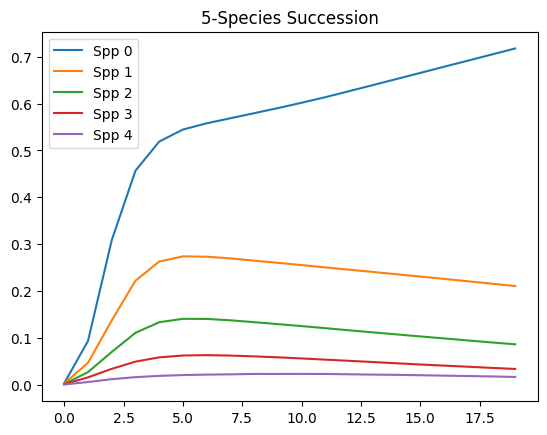

In [5]:
from ecosystem_model import EcosystemModel
import ecosystem_plotting as plot
import matplotlib.pyplot as plt

# Initialize with 5 Species!
# Creates competition between 5 different strategies
model = EcosystemModel(n_species=5, height=50, width=50)

# Customizing traits for 5 species gradient
# Species 0: Fast/Wasteful -> Species 4: Slow/Efficient
model.growth_rates.assign([0.3, 0.2, 0.15, 0.1, 0.05])
model.seed_probs.assign([0.05, 0.04, 0.03, 0.02, 0.01])

model.initialize_grid()

print("Running 5-Species Simulation...")
history = []

for i in range(200):
    model.step()

    if i % 10 == 0:
        state = model.get_state()
        # Biomass channels start at index 4 + (5*5) = 29
        # Spp 0 is at 29, Spp 1 at 30, etc.
        biomass_block = state[:, :, 29:] # Shape (H, W, 5)
        means = biomass_block.mean(axis=(0,1))
        history.append(means)

# Plot History
import numpy as np
hist_arr = np.array(history)
plt.plot(hist_arr)
plt.legend([f"Spp {i}" for i in range(5)])
plt.title("5-Species Succession")
plt.show()

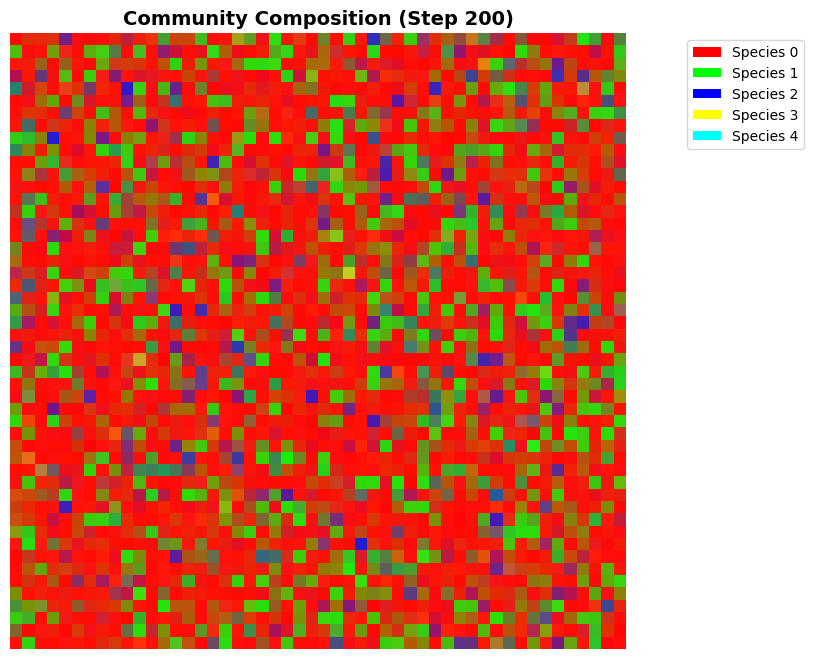

In [6]:
plot.plot_community_map(model.get_state(), timepoint="(Step 200)")

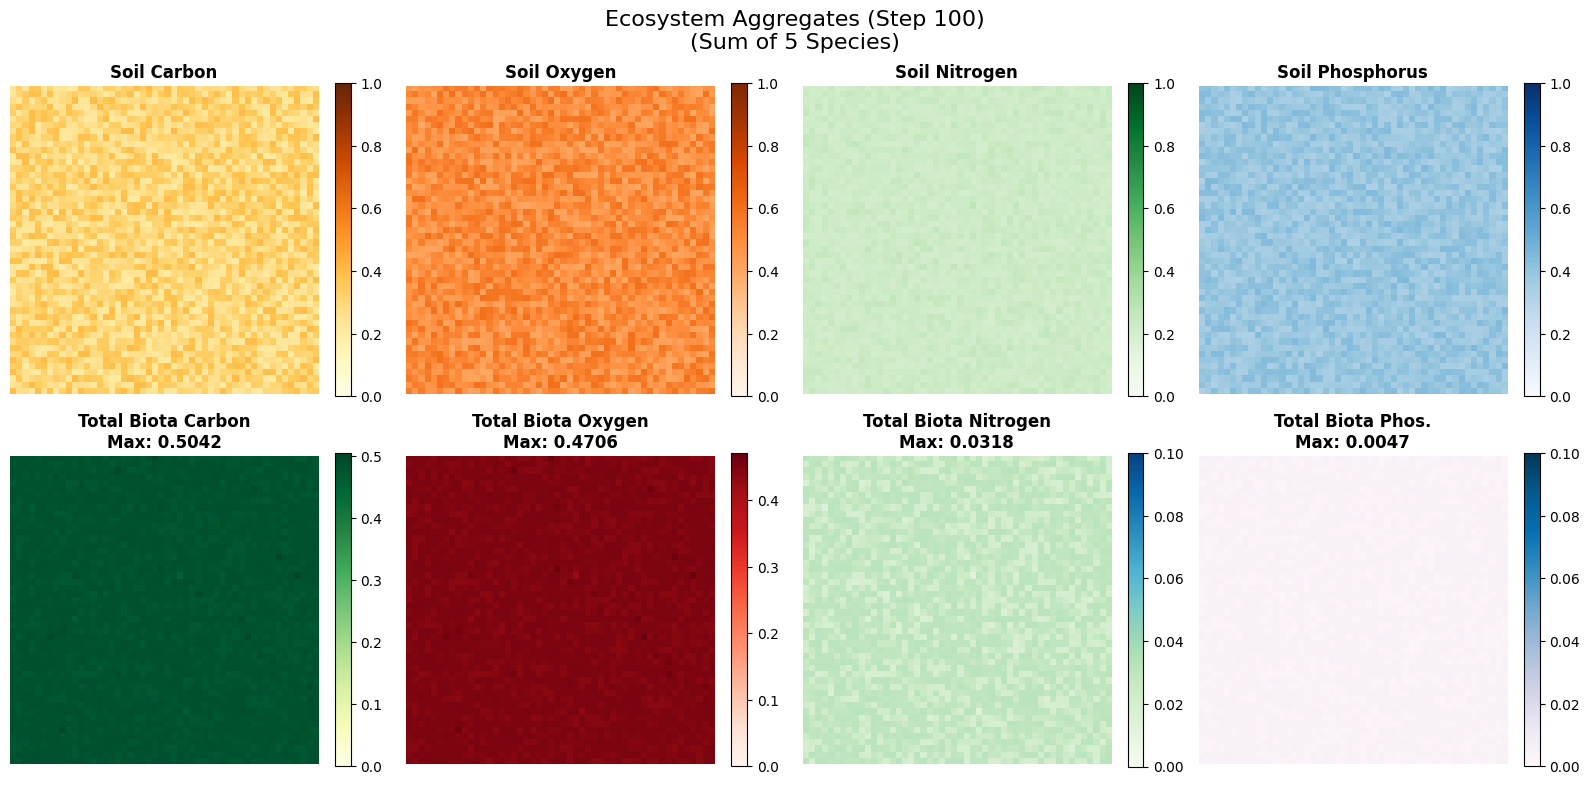

In [7]:
plot.plot_ecosystem_aggregate(model.get_state(), timepoint="(Step 100)")

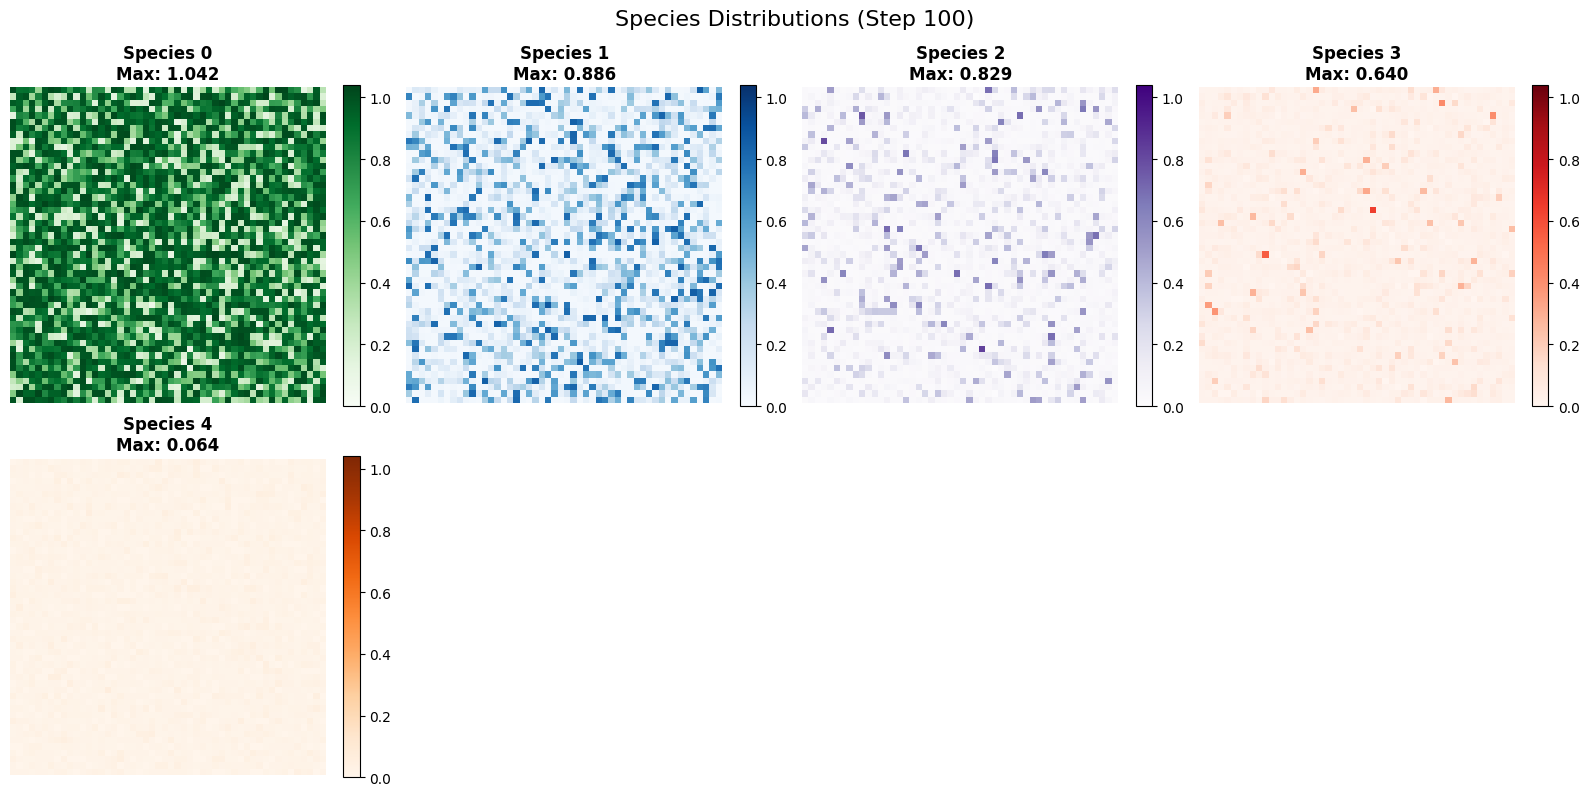

In [8]:
plot.plot_species_abundance(model.get_state(), timepoint="(Step 100)")